In [1]:
# install dependencies
! pip install pandas
! pip3 install torch --index-url https://download.pytorch.org/whl/cu128
! pip install ipdb
! pip install tqdm
! pip install pyarrow
! pip install matplotlib
! pip install scikit-learn
! pip install scipy

Looking in indexes: https://download.pytorch.org/whl/cu128


In [1]:
# import libraries
import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import pandas as pd
import glob
import torch
from torch.utils.data import Dataset, DataLoader, random_split, IterableDataset
import gc
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import time
from tqdm import tqdm
import pyarrow.dataset as ds
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
import json
from scipy.signal import find_peaks

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# ! cp drive/MyDrive/normalized-ids2018-parquet.tar.gz /content/
# ! tar -xzvf normalized-ids2018-parquet.tar.gz normalized/

In [3]:
PARQUET_FILES = glob.glob('normalized/*.parquet')
PARQUET_FILES_BENIGN = glob.glob('normalized-benign/*.parquet')
print(PARQUET_FILES)
print(PARQUET_FILES_BENIGN)

['normalized\\normalized_02-14-2018_part1.parquet', 'normalized\\normalized_02-15-2018_part1.parquet', 'normalized\\normalized_02-16-2018_part1.parquet', 'normalized\\normalized_02-20-2018_part1.parquet', 'normalized\\normalized_02-20-2018_part2.parquet', 'normalized\\normalized_02-20-2018_part3.parquet', 'normalized\\normalized_02-20-2018_part4.parquet', 'normalized\\normalized_02-20-2018_part5.parquet', 'normalized\\normalized_02-20-2018_part6.parquet', 'normalized\\normalized_02-20-2018_part7.parquet', 'normalized\\normalized_02-20-2018_part8.parquet', 'normalized\\normalized_02-21-2018_part1.parquet', 'normalized\\normalized_02-22-2018_part1.parquet', 'normalized\\normalized_02-23-2018_part1.parquet', 'normalized\\normalized_02-28-2018_part1.parquet', 'normalized\\normalized_03-01-2018_part1.parquet', 'normalized\\normalized_03-02-2018_part1.parquet']
['normalized-benign\\normalized_02-14-2018_part1-benign.parquet', 'normalized-benign\\normalized_02-15-2018_part1-benign.parquet', '

In [4]:
# canon columns
CANON_COLUMN_INDEX = ['Fwd IAT Tot', 'Fwd Pkt Len Min', 'Down/Up Ratio', 'Dst Port', 'Fwd IAT Std', 'Fwd Header Len', 'Fwd IAT Min', 'Flow IAT Std', 'Active Std', 'Bwd IAT Max', 'Fwd Pkt Len Mean', 'Pkt Size Avg', 'PSH Flag Cnt', 'Flow IAT Mean', 'Fwd Act Data Pkts', 'Bwd Pkt Len Max', 'Flow IAT Max', 'ACK Flag Cnt', 'Bwd IAT Tot', 'Flow IAT Min', 'Bwd Pkts/b Avg', 'Fwd IAT Max', 'SYN Flag Cnt', 'Bwd Header Len', 'Fwd Seg Size Avg', 'Bwd Byts/b Avg', 'Subflow Bwd Byts', 'Pkt Len Max', 'Bwd Pkts/s', 'Fwd IAT Mean', 'Pkt Len Var', 'Fwd Pkt Len Std', 'Protocol', 'Init Bwd Win Byts', 'Active Min', 'Src Port', 'RST Flag Cnt', 'Subflow Fwd Byts', 'Init Fwd Win Byts', 'Bwd Pkt Len Std', 'Fwd PSH Flags', 'Fwd Pkts/s', 'Bwd Blk Rate Avg', 'Flow Byts/s', 'CWE Flag Count', 'Pkt Len Std', 'Active Max', 'Fwd Byts/b Avg', 'Fwd Blk Rate Avg', 'URG Flag Cnt', 'Timestamp', 'Fwd Pkts/b Avg', 'Idle Mean', 'Idle Std', 'Fwd Pkt Len Max', 'Pkt Len Min', 'Flow Duration', 'Fwd Seg Size Min', 'Bwd IAT Min', 'TotLen Fwd Pkts', 'Flow Pkts/s', 'Active Mean', 'ECE Flag Cnt', 'Idle Min', 'Subflow Bwd Pkts', 'Bwd Pkt Len Mean', 'Pkt Len Mean', 'Tot Fwd Pkts', 'Bwd IAT Std', 'Bwd Seg Size Avg', 'Bwd URG Flags', 'Bwd Pkt Len Min', 'Tot Bwd Pkts', 'Subflow Fwd Pkts', 'Bwd IAT Mean', 'FIN Flag Cnt', 'Bwd PSH Flags', 'TotLen Bwd Pkts', 'Fwd URG Flags', 'Idle Max']
CANON_COLUMN_INDEX.sort()
CANON_COLUMN_INDEX.append('Label')
print(CANON_COLUMN_INDEX)
TRAINING_UNWANTED_COLUMNS = ['Timestamp', 'Flow ID', 'Dst IP', "Src IP"]
TRAINING_WANTED_COLUMNS = []
for col in CANON_COLUMN_INDEX:
  if col not in TRAINING_UNWANTED_COLUMNS:
    TRAINING_WANTED_COLUMNS.append(col)
print(TRAINING_WANTED_COLUMNS)
TRAINING_FEATURES = TRAINING_WANTED_COLUMNS[:-1]

['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd PSH Flags', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/b Avg', 'Bwd Pkts/s', 'Bwd Seg Size Avg', 'Bwd URG Flags', 'CWE Flag Count', 'Down/Up Ratio', 'Dst Port', 'ECE Flag Cnt', 'FIN Flag Cnt', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Blk Rate Avg', 'Fwd Byts/b Avg', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd PSH Flags', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/b Avg', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Fwd Seg Size Min', 'Fwd URG Flags', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Init Fwd Win Byts', 'PSH Flag Cnt

In [23]:
# pyarrow parquet dataset
class ArrowParquetDataset(IterableDataset):
    def __init__(self, path, batch_size=1024, shuffle=True, splits=(0.7,0.1,0.2)):
        self.path = path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.splits = (splits[0],splits[1], splits[2], 1.0)
        self.mode("train")

        self.dataset = ds.dataset(self.path, format="parquet")
        self.scanner = self.dataset.scanner(columns=TRAINING_WANTED_COLUMNS, batch_size=self.batch_size)

    def mode(self, m):
        match m:
            case "train":
                self.mode_value = 0
            case "val":
                self.mode_value = 1
            case "test":
                self.mode_value = 2
            case "full":
                self.mode_value = 3

    # approximate iterations
    def num_iterations(self):
        return int((len(self) * self.splits[self.mode_value]) / self.batch_size)

    def __len__(self):
        return self.scanner.count_rows()

    def __iter__(self):
        batches = list(self.scanner.to_batches())

        num_batches = len(batches)
        train_end = int(num_batches * self.splits[0])
        val_end = train_end + int(num_batches * self.splits[1])

        match self.mode_value:
            case 0:
                batches = batches[:train_end]
            case 1:
                batches = batches[train_end:val_end]
            case 2:
                batches = batches[val_end:]
            case 3: 
                batches = batches

        if self.shuffle:
            random.shuffle(batches)

        for batch in batches:
            x = batch.select(TRAINING_FEATURES).to_tensor(null_to_nan=True)
            
            y_string_array = batch.column("Label")
            y = torch.tensor([(0.0 if val.as_py() == "Benign" else 1.0) for val in y_string_array], dtype=torch.float32)
            x = torch.tensor(x, dtype=torch.float32)

            # in val and train modes ignore intrusions
            if (self.mode_value == 0 or self.mode_value == 1):
                benign_mask = (y == 0.0)
                x = x[benign_mask]
                y = y[benign_mask]

            # # add randomness to generalize in training
            # if self.mode_value == 0:
            #     x = x + 0.01 * torch.randn_like(x)

            
            
            # mask and impute nans
            mask = torch.isnan(x).float()
            x = torch.nan_to_num(x, nan=0.0)
            x = torch.cat([x, mask], dim=1)
            
            yield x, y

DS_ARROW = ArrowParquetDataset(PARQUET_FILES, batch_size=512)
print(len(DS_ARROW))

16233002


In [29]:
# dnn model
class DNN(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(DNN, self).__init__()

    #layers
    self.input = nn.Linear(input_size, hidden_sizes[0])
    self.output = nn.Linear(hidden_sizes[-1], output_size)
    self.dropout = nn.Dropout(0.6)
    self.hiddens = nn.ModuleList()
    for i in range(len(hidden_sizes) - 1):
      self.hiddens.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

  def forward(self, x):
    x = F.relu(self.input(x))
    for layer in self.hiddens:
      x = F.relu(layer(x))
    x = self.dropout(x)
    x = self.output(x)
    # return torch.sigmoid(x).view(-1)
    return x


In [30]:
# create model
input_shape = len(TRAINING_FEATURES) * 2 # because masking

# autoencoder
model = DNN(
    input_shape,
    [int(input_shape / 2)],
    input_shape
)

model_desc = model.__str__()
print(model_desc)

DNN(
  (input): Linear(in_features=158, out_features=79, bias=True)
  (output): Linear(in_features=79, out_features=158, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (hiddens): ModuleList()
)


In [31]:
# train
torch.cuda.empty_cache()

model.to(device)
loss_fn = nn.MSELoss()
loss_fn_no_reduction = nn.MSELoss(reduction='none')
lr = 0.00001
beta1 = 0.9
beta2 = 0.999
weight_decay = 0.01
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1,beta2), weight_decay=weight_decay)
epochs = 15
train_loss = -1

reconstruction_l2 = 0.0

historical_loss = []
historical_val_loss = []
historical_reconstruction = []

train_start_time = time.time()
for epoch in range(epochs):
  epoch_loss = 0.0
  epoch_val_loss = 0.0

  model.train()
  epoch_samples = 0
  DS_ARROW.mode("train")
  for x, _ in tqdm(DS_ARROW, total=DS_ARROW.num_iterations()):
    x = x.to(device)
    batch_size = x.size()[0]
    if batch_size == 0: continue
    epoch_samples += batch_size

    optim.zero_grad()
    out = model(x)
    loss = loss_fn(out, x)
    loss.backward()
    optim.step()
    epoch_loss += loss.item() * batch_size

  epoch_loss = epoch_loss / epoch_samples

  epoch_l2s = []

  model.eval()
  epoch_val_samples = 0
  DS_ARROW.mode("val")
  with torch.no_grad():
    for x, _ in tqdm(DS_ARROW, total=DS_ARROW.num_iterations()):
      x = x.to(device)
      batch_size = x.size()[0]
      if batch_size == 0: continue
      epoch_val_samples += batch_size

      out = model(x)
      loss = loss_fn(out, x)
      epoch_val_loss += loss.item() * batch_size

      reconstruction_losses = loss_fn_no_reduction(out,x)
      l2_dists = torch.norm(reconstruction_losses, p=2, dim=1)
      epoch_l2s.append(l2_dists)

  epoch_val_loss = epoch_val_loss / epoch_val_samples
  historical_val_loss.append(epoch_val_loss)
  historical_loss.append(epoch_loss)

  l2s_tensor = torch.concat(epoch_l2s)
  l2s_mean = l2s_tensor.mean().item()
  l2s_std = l2s_tensor.std().item()
  print(f"unfiltered mean: {l2s_mean:.5f}, std: {l2s_std:.5f}")
  l2s_filtered = l2s_tensor[(l2s_tensor >= (l2s_mean - 2 * l2s_std)) & (l2s_tensor <= (l2s_mean + 2 * l2s_std))]
  filtered_mean = l2s_filtered.mean().item()
  filtered_std = l2s_filtered.std().item()
  print(f"filtered mean: {filtered_mean:.5f}, std: {filtered_std:.5f}")
  reconstruction_l2 = filtered_mean + filtered_std
  historical_reconstruction.append(reconstruction_l2)

  print(f'epoch: {epoch + 1}/{epochs}, train loss: {epoch_loss:.5f}, val loss: {epoch_val_loss:.5f}, val reconstruction: {reconstruction_l2:.5f}')
  train_loss = epoch_loss
min, sec = divmod(int(time.time() - train_start_time), 60)
print(f'train time: {min}:{sec}')

22196it [01:26, 255.51it/s]                           
100%|██████████| 3170/3170 [00:15<00:00, 208.47it/s]


unfiltered mean: 66.82999, std: 25299.87305
filtered mean: 12.20708, std: 204.14276
epoch: 1/15, train loss: 0.28415, val loss: 1.00432, val reconstruction: 216.34984


22196it [01:23, 265.38it/s]                           
100%|██████████| 3170/3170 [00:14<00:00, 214.68it/s]


unfiltered mean: 65.86420, std: 25325.02734
filtered mean: 11.21143, std: 156.48848
epoch: 2/15, train loss: 0.19991, val loss: 0.98606, val reconstruction: 167.69991


22196it [01:22, 268.34it/s]                           
100%|██████████| 3170/3170 [00:12<00:00, 244.13it/s]


unfiltered mean: 65.34086, std: 25326.29297
filtered mean: 10.70286, std: 113.20280
epoch: 3/15, train loss: 0.18494, val loss: 0.97676, val reconstruction: 123.90567


22196it [01:26, 256.89it/s]                           
100%|██████████| 3170/3170 [00:13<00:00, 234.74it/s]


unfiltered mean: 64.98547, std: 25325.57031
filtered mean: 10.39160, std: 90.62426
epoch: 4/15, train loss: 0.17878, val loss: 0.97110, val reconstruction: 101.01586


22196it [01:19, 279.99it/s]                           
100%|██████████| 3170/3170 [00:12<00:00, 243.97it/s]


unfiltered mean: 64.80460, std: 25328.46094
filtered mean: 10.20517, std: 71.92543
epoch: 5/15, train loss: 0.17544, val loss: 0.96823, val reconstruction: 82.13060


22196it [01:20, 274.30it/s]                           
100%|██████████| 3170/3170 [00:13<00:00, 232.37it/s]


unfiltered mean: 64.70287, std: 25325.24805
filtered mean: 10.10925, std: 62.73296
epoch: 6/15, train loss: 0.17363, val loss: 0.96627, val reconstruction: 72.84221


22196it [01:20, 275.91it/s]                           
100%|██████████| 3170/3170 [00:13<00:00, 237.04it/s]


unfiltered mean: 64.60037, std: 25322.55078
filtered mean: 10.01219, std: 57.80301
epoch: 7/15, train loss: 0.17206, val loss: 0.96462, val reconstruction: 67.81519


22196it [01:19, 279.56it/s]                           
100%|██████████| 3170/3170 [00:12<00:00, 247.73it/s]


unfiltered mean: 64.58064, std: 25323.33594
filtered mean: 9.99101, std: 55.61899
epoch: 8/15, train loss: 0.17138, val loss: 0.96372, val reconstruction: 65.61000


22196it [01:22, 268.09it/s]                           
100%|██████████| 3170/3170 [00:13<00:00, 242.19it/s]


unfiltered mean: 64.56014, std: 25324.05859
filtered mean: 9.96832, std: 55.23568
epoch: 9/15, train loss: 0.17054, val loss: 0.96326, val reconstruction: 65.20400


22196it [01:22, 270.32it/s]                           
100%|██████████| 3170/3170 [00:13<00:00, 232.31it/s]


unfiltered mean: 64.54819, std: 25326.81250
filtered mean: 9.95116, std: 53.80231
epoch: 10/15, train loss: 0.17006, val loss: 0.96299, val reconstruction: 63.75347


22196it [01:20, 274.93it/s]                           
100%|██████████| 3170/3170 [00:14<00:00, 220.93it/s]


unfiltered mean: 64.52475, std: 25323.85156
filtered mean: 9.93425, std: 54.27549
epoch: 11/15, train loss: 0.16945, val loss: 0.96271, val reconstruction: 64.20973


22196it [01:20, 274.43it/s]                           
100%|██████████| 3170/3170 [00:13<00:00, 234.31it/s]


unfiltered mean: 64.49203, std: 25323.99414
filtered mean: 9.90062, std: 51.63791
epoch: 12/15, train loss: 0.16923, val loss: 0.96228, val reconstruction: 61.53853


22196it [01:20, 277.17it/s]                           
100%|██████████| 3170/3170 [00:12<00:00, 254.80it/s]


unfiltered mean: 64.46142, std: 25323.31055
filtered mean: 9.87128, std: 50.93930
epoch: 13/15, train loss: 0.16907, val loss: 0.96160, val reconstruction: 60.81057


22196it [01:29, 249.36it/s]                           
100%|██████████| 3170/3170 [00:14<00:00, 213.90it/s]


unfiltered mean: 64.45833, std: 25325.97656
filtered mean: 9.86304, std: 49.78708
epoch: 14/15, train loss: 0.16889, val loss: 0.96141, val reconstruction: 59.65013


22196it [01:21, 272.01it/s]                           
100%|██████████| 3170/3170 [00:14<00:00, 222.42it/s]


unfiltered mean: 64.41425, std: 25324.89258
filtered mean: 9.82085, std: 49.16698
epoch: 15/15, train loss: 0.16837, val loss: 0.96085, val reconstruction: 58.98783
train time: 24:2


In [38]:
# test
model.eval()
test_loss = 0.0
test_start_time = time.time()

historical_label_tensor = []
historical_pred_tensor = []

DS_ARROW.mode("test")
epoch_samples = 0
with torch.no_grad():
  for x, y in tqdm(DS_ARROW, total=DS_ARROW.num_iterations()):
    x = x.to(device)
    y = y.to(device)
    batch_size = x.size()[0]
    epoch_samples += batch_size

    out = model(x)
    reconstruction_losses = loss_fn_no_reduction(out, x)
    l2_dists = torch.norm(reconstruction_losses, p=2, dim=1)
    thresholded = (l2_dists > reconstruction_l2).float()
    for i, l in enumerate(l2_dists):
      print(y[i].item(), thresholded[i].item(), l.item())
    test_loss += torch.isclose(thresholded, y).float().sum().item()

    if random.random() < 0.05:
      historical_label_tensor.append(y.to("cpu"))
      historical_pred_tensor.append(thresholded.to("cpu"))

test_loss = test_loss / epoch_samples
print(f'test loss (accuracy): {test_loss:.5f}')
min, sec = divmod(int(time.time() - test_start_time), 60)
print(f'test time: {min}:{sec}')
print(f"samples: {len(historical_label_tensor) * DS_ARROW.batch_size}/{epoch_samples} {(len(historical_label_tensor) * DS_ARROW.batch_size / epoch_samples) * 100:.2f}%")

  0%|          | 1/6341 [00:06<11:58:15,  6.80s/it]

0.0 0.0 1.3621408939361572
0.0 0.0 1.4435774087905884
0.0 0.0 1.3621684312820435
0.0 0.0 1.443515419960022
0.0 0.0 1.3621091842651367
0.0 0.0 1.4438084363937378
0.0 0.0 1.3621598482131958
0.0 0.0 1.443515419960022
0.0 0.0 1.3621327877044678
0.0 0.0 1.4436081647872925
0.0 0.0 1.3621619939804077
0.0 0.0 1.4436081647872925
0.0 0.0 1.3621891736984253
0.0 0.0 1.4435466527938843
0.0 0.0 1.4273581504821777
0.0 0.0 1.4488308429718018
0.0 0.0 1.5454081296920776
0.0 0.0 8.0235595703125
0.0 0.0 2.3493006229400635
0.0 0.0 1.4273608922958374
0.0 0.0 5.444986343383789
0.0 0.0 1.4273682832717896
0.0 0.0 1.427368402481079
0.0 0.0 1.7438009977340698
0.0 0.0 1.448832631111145
0.0 0.0 1.545202374458313
0.0 0.0 1.7437982559204102
0.0 0.0 1.4273678064346313
0.0 0.0 1.427368402481079
0.0 0.0 1.4593586921691895
0.0 0.0 1.593632459640503
0.0 0.0 1.443604588508606
0.0 0.0 1.362093210220337
0.0 0.0 1.4434514045715332
0.0 0.0 1.4273581504821777
0.0 0.0 1.7437992095947266
0.0 0.0 1.3773436546325684
0.0 0.0 1.4488

  0%|          | 3/6341 [00:06<3:13:16,  1.83s/it] 

0.0 0.0 3.4046554565429688
0.0 0.0 3.38645601272583
0.0 0.0 1.9886069297790527
0.0 0.0 0.640988290309906
0.0 0.0 13.636415481567383
0.0 0.0 0.687414824962616
0.0 0.0 0.5292067527770996
0.0 0.0 3.4069340229034424
0.0 0.0 0.5290033221244812
0.0 0.0 3.291889190673828
0.0 0.0 0.5790389776229858
0.0 0.0 13.584176063537598
0.0 0.0 13.617870330810547
0.0 0.0 2.1656453609466553
0.0 0.0 3.4046261310577393
0.0 0.0 1.7727962732315063
0.0 0.0 2.394458770751953
0.0 0.0 2.1349618434906006
0.0 0.0 3.6300711631774902
0.0 0.0 2.5524654388427734
0.0 0.0 0.39231300354003906
0.0 0.0 0.42472395300865173
0.0 0.0 3.7055160999298096
0.0 0.0 13.613577842712402
0.0 0.0 0.5170559883117676
0.0 0.0 2.360433340072632
0.0 0.0 3.4042418003082275
0.0 0.0 3.563941240310669
0.0 0.0 3.2492403984069824
0.0 0.0 0.5791047811508179
0.0 0.0 0.6397505402565002
0.0 0.0 3.4703803062438965
0.0 0.0 5.416221618652344
0.0 0.0 3.6790525913238525
0.0 0.0 2.893977642059326
0.0 0.0 3.3537075519561768
0.0 0.0 0.5465665459632874
0.0 0.0 3

  0%|          | 5/6341 [00:07<1:39:06,  1.07it/s]

0.0 0.0 8.940775871276855
0.0 1.0 78.15157318115234
0.0 0.0 3.073434352874756
0.0 0.0 3.2622151374816895
0.0 0.0 10.109522819519043
0.0 0.0 14.360806465148926
0.0 0.0 1.4488879442214966
0.0 0.0 1.548107385635376
0.0 0.0 0.5461490154266357
0.0 0.0 19.179943084716797
0.0 0.0 12.241005897521973
0.0 1.0 461.7469787597656
0.0 0.0 1.4488105773925781
0.0 0.0 1.5426464080810547
0.0 0.0 1.7438043355941772
0.0 0.0 5.444988250732422
0.0 0.0 1.4488617181777954
0.0 0.0 1.541137933731079
0.0 0.0 4.922998905181885
0.0 0.0 4.21837043762207
0.0 0.0 1.5937137603759766
0.0 0.0 1.4435433149337769
0.0 0.0 1.3622217178344727
0.0 0.0 1.4434185028076172
0.0 0.0 19.17876625061035
0.0 0.0 1.448881983757019
0.0 0.0 1.540385365486145
0.0 0.0 0.693001925945282
0.0 0.0 0.5983636379241943
0.0 0.0 0.5461109280586243
0.0 0.0 0.5791023969650269
0.0 0.0 5.404745101928711
0.0 0.0 2.415712833404541
0.0 0.0 5.4031877517700195
0.0 0.0 0.5982538461685181
0.0 0.0 1.408139944076538
0.0 0.0 3.63153338432312
0.0 0.0 9.0088920593

  0%|          | 9/6341 [00:07<41:45,  2.53it/s]  

0.0 0.0 0.7707815766334534
0.0 0.0 0.450676292181015
0.0 0.0 0.6215647459030151
0.0 0.0 0.5168667435646057
0.0 0.0 3.560986042022705
0.0 0.0 12.833340644836426
0.0 0.0 17.458499908447266
0.0 0.0 3.4043502807617188
0.0 0.0 0.3866480886936188
0.0 0.0 0.5331862568855286
0.0 0.0 1.1528936624526978
0.0 0.0 0.6880092024803162
0.0 0.0 2.339719772338867
0.0 0.0 4.189887523651123
0.0 0.0 12.837543487548828
0.0 0.0 4.139682292938232
0.0 0.0 0.3857329487800598
0.0 0.0 1.2664695978164673
0.0 0.0 1.692259430885315
0.0 0.0 12.678909301757812
0.0 0.0 0.44830337166786194
0.0 0.0 3.2487568855285645
0.0 0.0 1.6578272581100464
0.0 0.0 0.47664520144462585
0.0 0.0 3.520951986312866
0.0 0.0 12.152022361755371
0.0 0.0 2.6265487670898438
0.0 0.0 1.3865232467651367
0.0 0.0 0.9473856687545776
0.0 0.0 1.7489476203918457
0.0 0.0 0.613287091255188
0.0 0.0 0.6874198317527771
0.0 0.0 0.7668836116790771
0.0 0.0 4.237152576446533
0.0 0.0 12.994800567626953
0.0 0.0 13.588706016540527
0.0 0.0 12.361762046813965
0.0 0.0 

  0%|          | 11/6341 [00:07<30:28,  3.46it/s]

1.0 0.0 1.1553058624267578
1.0 0.0 5.053557395935059
1.0 0.0 1.1553512811660767
1.0 0.0 5.053596019744873
1.0 0.0 1.1555207967758179
1.0 0.0 5.053572177886963
1.0 0.0 1.1552578210830688
1.0 0.0 5.053590297698975
1.0 0.0 1.155312418937683
1.0 0.0 5.053585052490234
1.0 0.0 1.155295729637146
1.0 0.0 5.053590297698975
1.0 0.0 1.1553288698196411
1.0 0.0 5.053576469421387
1.0 0.0 1.155662178993225
1.0 0.0 5.053577423095703
1.0 0.0 1.1558489799499512
1.0 0.0 5.053594589233398
1.0 0.0 1.1557449102401733
1.0 0.0 5.053584098815918
1.0 0.0 1.155590534210205
1.0 0.0 5.053568363189697
1.0 0.0 1.1555577516555786
1.0 0.0 5.053577899932861
1.0 0.0 1.1587802171707153
1.0 0.0 5.053555488586426
1.0 0.0 1.1551953554153442
1.0 0.0 5.053602695465088
1.0 0.0 1.1553322076797485
1.0 0.0 5.053577423095703
1.0 0.0 1.1589564085006714
1.0 0.0 5.053602695465088
1.0 0.0 1.1552857160568237
1.0 0.0 5.053587913513184
1.0 0.0 1.1552435159683228
1.0 0.0 5.053590297698975
1.0 0.0 1.1592413187026978
1.0 0.0 5.0535602569580

  0%|          | 13/6341 [00:07<23:30,  4.48it/s]

0.0 0.0 9.016487121582031
0.0 0.0 11.025229454040527
0.0 0.0 3.5716781616210938
0.0 0.0 9.02180290222168
0.0 0.0 9.016304016113281
0.0 0.0 7.646621227264404
0.0 0.0 9.018847465515137
0.0 0.0 7.646627902984619
0.0 0.0 9.01827335357666
0.0 0.0 3.7708208560943604
0.0 0.0 9.043270111083984
0.0 0.0 5.886661529541016
0.0 0.0 9.017908096313477
0.0 0.0 4.684920787811279
0.0 0.0 4.684927463531494
0.0 0.0 2.2365682125091553
0.0 0.0 2.2582144737243652
0.0 0.0 5.4758830070495605
0.0 0.0 5.282802104949951
0.0 0.0 4.965924263000488
0.0 0.0 7.967165946960449
0.0 0.0 5.090658187866211
0.0 0.0 8.983418464660645
0.0 0.0 9.018701553344727
0.0 0.0 9.018730163574219
0.0 0.0 6.190749645233154
0.0 0.0 4.161951065063477
0.0 0.0 5.262466907501221
0.0 1.0 74.04981231689453
0.0 0.0 8.975049018859863
0.0 0.0 7.335354804992676
0.0 0.0 3.077179193496704
0.0 0.0 1.426029086112976
0.0 0.0 4.863933086395264
0.0 0.0 1.425966739654541
0.0 0.0 3.1769394874572754
0.0 0.0 3.1765518188476562
0.0 0.0 22.081417083740234
0.0 0

  0%|          | 15/6341 [00:08<19:02,  5.54it/s]

0.0 0.0 2.170687675476074
0.0 0.0 2.187706708908081
0.0 0.0 3.3320231437683105
0.0 1.0 124.49152374267578
0.0 0.0 14.872237205505371
0.0 0.0 8.95226001739502
0.0 0.0 8.941837310791016
0.0 0.0 2.204974889755249
0.0 0.0 8.982962608337402
0.0 0.0 14.839851379394531
0.0 0.0 14.344023704528809
0.0 0.0 12.413960456848145
0.0 0.0 12.308614730834961
0.0 0.0 8.937039375305176
0.0 0.0 8.9397611618042
0.0 0.0 8.943350791931152
0.0 0.0 8.944087982177734
0.0 1.0 78.17343139648438
0.0 0.0 2.205500841140747
0.0 0.0 2.204807758331299
0.0 0.0 11.79300594329834
0.0 0.0 10.656143188476562
0.0 0.0 11.882034301757812
0.0 0.0 13.570343017578125
0.0 0.0 8.936972618103027
0.0 0.0 8.943571090698242
0.0 0.0 9.042869567871094
0.0 0.0 8.943643569946289
0.0 0.0 9.039632797241211
0.0 0.0 8.945012092590332
0.0 0.0 2.1733298301696777
0.0 1.0 78.17314910888672
0.0 1.0 78.17433166503906
0.0 0.0 2.206507444381714
0.0 0.0 2.205233573913574
0.0 0.0 12.688584327697754
0.0 0.0 10.609639167785645
0.0 0.0 10.818281173706055
0

  0%|          | 17/6341 [00:08<16:22,  6.43it/s]

0.0 0.0 8.589476585388184
0.0 0.0 7.318166255950928
0.0 0.0 8.134364128112793
0.0 0.0 9.613771438598633
0.0 0.0 8.142949104309082
0.0 0.0 8.399703025817871
0.0 0.0 8.678367614746094
0.0 0.0 7.874080181121826
0.0 0.0 2.3222427368164062
0.0 0.0 2.1523871421813965
0.0 0.0 2.1495473384857178
0.0 0.0 9.712767601013184
0.0 0.0 8.371519088745117
0.0 0.0 2.1534509658813477
0.0 0.0 2.1523940563201904
0.0 0.0 2.1534581184387207
0.0 0.0 11.477690696716309
0.0 0.0 20.21465492248535
0.0 0.0 9.814105987548828
0.0 1.0 200.23574829101562
0.0 0.0 3.9096295833587646
0.0 0.0 12.94975471496582
0.0 0.0 10.982596397399902
0.0 0.0 1.4220308065414429
0.0 0.0 11.825301170349121
0.0 1.0 461.81158447265625
0.0 0.0 1.4220138788223267
0.0 0.0 13.944133758544922
0.0 0.0 5.1652374267578125
0.0 0.0 3.8188536167144775
0.0 0.0 7.200943946838379
0.0 0.0 13.023268699645996
0.0 0.0 14.948136329650879
0.0 0.0 15.511308670043945
0.0 0.0 8.637149810791016
0.0 0.0 12.171709060668945
0.0 0.0 8.941463470458984
0.0 0.0 8.9420166

  0%|          | 19/6341 [00:08<14:12,  7.41it/s]

0.0 0.0 2.523029327392578
0.0 0.0 1.65802800655365
0.0 0.0 1.6584217548370361
0.0 0.0 3.223466634750366
0.0 0.0 0.658820629119873
0.0 0.0 13.655402183532715
0.0 0.0 3.645150899887085
0.0 0.0 3.40444016456604
0.0 0.0 1.6583526134490967
0.0 0.0 2.6622583866119385
0.0 0.0 1.6579842567443848
0.0 0.0 3.330132484436035
0.0 0.0 3.1569344997406006
0.0 0.0 3.2715182304382324
0.0 0.0 2.0673491954803467
0.0 1.0 196.3914031982422
0.0 0.0 0.46495774388313293
0.0 0.0 1.5832533836364746
0.0 0.0 3.2592763900756836
0.0 0.0 3.404528856277466
0.0 0.0 1.6579301357269287
0.0 0.0 2.519226312637329
0.0 0.0 13.739494323730469
0.0 0.0 3.7785184383392334
0.0 0.0 0.44695109128952026
0.0 0.0 3.249385356903076
0.0 0.0 0.4718921184539795
0.0 0.0 2.2114434242248535
0.0 0.0 0.5790595412254333
0.0 0.0 3.5048389434814453
0.0 0.0 3.390578031539917
0.0 0.0 1.205389380455017
0.0 0.0 13.59423542022705
0.0 0.0 13.635826110839844
0.0 0.0 0.35166823863983154
0.0 0.0 3.02356219291687
0.0 0.0 0.42369553446769714
0.0 0.0 0.44914

  0%|          | 21/6341 [00:08<13:04,  8.05it/s]

1.0 0.0 1.1552889347076416
1.0 0.0 5.0536417961120605
1.0 0.0 1.1554710865020752
1.0 0.0 5.053670406341553
1.0 0.0 1.1554491519927979
0.0 0.0 5.444916725158691
1.0 0.0 5.053658962249756
1.0 0.0 1.1555331945419312
1.0 0.0 5.053647518157959
1.0 0.0 1.1553322076797485
1.0 0.0 5.053343772888184
1.0 0.0 1.1553288698196411
1.0 0.0 5.053607940673828
1.0 0.0 1.1554149389266968
1.0 0.0 5.05352783203125
1.0 0.0 1.155354380607605
1.0 0.0 5.053532123565674
1.0 0.0 1.1553574800491333
1.0 0.0 5.053646087646484
1.0 0.0 1.1554406881332397
1.0 0.0 5.053635597229004
1.0 0.0 1.1553122997283936
1.0 0.0 5.053619861602783
1.0 0.0 1.1553912162780762
1.0 0.0 5.053598403930664
1.0 0.0 1.1557505130767822
1.0 0.0 5.0535736083984375
1.0 0.0 1.15536367893219
1.0 0.0 5.053640842437744
1.0 0.0 1.1553822755813599
1.0 0.0 5.0536017417907715
1.0 0.0 1.1553881168365479
1.0 0.0 5.053658485412598
1.0 0.0 1.1553606986999512
1.0 0.0 5.0536417961120605
1.0 0.0 1.155344843864441
1.0 0.0 5.053542613983154
1.0 0.0 1.15536689758

  0%|          | 23/6341 [00:08<12:06,  8.70it/s]

0.0 0.0 1.7004139423370361
0.0 0.0 0.6959025859832764
0.0 0.0 0.8186160922050476
0.0 0.0 5.352165699005127
0.0 0.0 3.398226499557495
0.0 0.0 0.6124228239059448
1.0 0.0 6.45189905166626
1.0 0.0 6.820826053619385
0.0 0.0 22.509347915649414
0.0 0.0 13.521702766418457
0.0 0.0 0.518330454826355
0.0 0.0 3.4345908164978027
0.0 0.0 0.5984548330307007
1.0 0.0 0.5515386462211609
0.0 0.0 13.526887893676758
0.0 0.0 0.523374080657959
1.0 0.0 0.4812547564506531
0.0 0.0 3.3963217735290527
1.0 0.0 0.4071256220340729
1.0 0.0 5.85814094543457
1.0 0.0 0.5977213978767395
0.0 0.0 2.1931419372558594
0.0 0.0 3.223442792892456
0.0 0.0 1.046037197113037
0.0 0.0 13.508821487426758
0.0 0.0 3.441777467727661
0.0 0.0 0.542768120765686
0.0 0.0 3.4186012744903564
0.0 0.0 0.36640313267707825
0.0 0.0 0.4535020887851715
0.0 0.0 3.354717969894409
0.0 0.0 0.3530353605747223
0.0 0.0 3.3577935695648193
1.0 0.0 7.253316879272461
0.0 0.0 13.531588554382324
0.0 0.0 2.552577257156372
0.0 0.0 0.5286049246788025
0.0 0.0 5.763578

  0%|          | 25/6341 [00:09<11:09,  9.44it/s]

0.0 0.0 10.280632019042969
0.0 0.0 40.18589782714844
0.0 0.0 7.862759113311768
0.0 0.0 7.865499973297119
0.0 0.0 7.867045879364014
0.0 0.0 7.859134197235107
0.0 0.0 7.869158744812012
0.0 0.0 7.931580066680908
0.0 0.0 10.017489433288574
0.0 0.0 4.784860610961914
0.0 0.0 1.5936346054077148
0.0 0.0 1.444010853767395
0.0 0.0 1.3622015714645386
0.0 0.0 1.4435466527938843
0.0 0.0 1.4487967491149902
0.0 0.0 1.5426251888275146
0.0 0.0 5.444981098175049
0.0 0.0 11.6724214553833
0.0 0.0 8.936433792114258
0.0 0.0 2.099555253982544
0.0 0.0 11.796059608459473
0.0 0.0 8.937215805053711
0.0 0.0 2.023531913757324
0.0 0.0 14.27029800415039
0.0 0.0 8.937487602233887
0.0 0.0 2.125199556350708
0.0 0.0 1.545677900314331
0.0 1.0 78.18810272216797
0.0 0.0 14.720081329345703
0.0 0.0 16.408767700195312
0.0 0.0 13.3861665725708
0.0 0.0 17.753467559814453
0.0 0.0 3.073427677154541
0.0 0.0 3.262355089187622
0.0 0.0 8.939016342163086
0.0 0.0 8.942228317260742
0.0 0.0 8.943879127502441
0.0 0.0 8.943853378295898
0.0

  0%|          | 29/6341 [00:09<10:27, 10.06it/s]

0.0 0.0 1.6674379110336304
0.0 0.0 1.4459739923477173
0.0 0.0 0.8040779829025269
0.0 0.0 1.6869982481002808
0.0 0.0 9.013949394226074
0.0 0.0 2.434964418411255
0.0 0.0 1.4269912242889404
0.0 0.0 2.527463674545288
0.0 0.0 1.4270042181015015
0.0 0.0 3.8905327320098877
0.0 0.0 12.733733177185059
0.0 0.0 4.053470134735107
0.0 0.0 3.3999359607696533
0.0 0.0 1.4252699613571167
0.0 0.0 3.102121353149414
0.0 0.0 1.4275676012039185
0.0 0.0 1.4488052129745483
0.0 0.0 1.5420386791229248
0.0 0.0 1.743795394897461
0.0 0.0 1.3667422533035278
0.0 0.0 2.9482128620147705
0.0 0.0 1.4446954727172852
0.0 0.0 2.895730972290039
0.0 0.0 1.4449409246444702
0.0 0.0 1.743798851966858
0.0 0.0 2.237205743789673
0.0 0.0 2.041877269744873
0.0 0.0 2.177797317504883
0.0 0.0 2.047616720199585
1.0 0.0 0.5983041524887085
0.0 0.0 3.2293596267700195
0.0 0.0 10.759559631347656
0.0 0.0 22.57813835144043
0.0 0.0 0.5629760026931763
1.0 0.0 0.6028816103935242
0.0 0.0 13.520068168640137
1.0 0.0 0.39576515555381775
1.0 0.0 3.229

  0%|          | 31/6341 [00:09<10:33,  9.95it/s]

0.0 0.0 1.4205912351608276
0.0 0.0 15.649625778198242
0.0 0.0 5.114675998687744
0.0 0.0 1.743800163269043
0.0 0.0 21.22968292236328
0.0 0.0 2.3472955226898193
0.0 0.0 1.4190086126327515
0.0 0.0 1.4488253593444824
0.0 0.0 41.30956268310547
0.0 0.0 1.5582786798477173
0.0 0.0 8.845308303833008
0.0 0.0 2.025330066680908
0.0 0.0 4.095386028289795
0.0 0.0 3.8570950031280518
0.0 0.0 10.057445526123047
0.0 0.0 9.306421279907227
0.0 0.0 7.037298679351807
0.0 0.0 2.0515034198760986
0.0 0.0 11.80848217010498
0.0 0.0 9.501310348510742
0.0 0.0 9.90556812286377
0.0 0.0 15.56261920928955
0.0 0.0 7.809757232666016
0.0 0.0 8.951412200927734
0.0 0.0 7.192178249359131
0.0 0.0 8.82468032836914
0.0 0.0 2.083164691925049
0.0 0.0 2.0149881839752197
0.0 0.0 8.728477478027344
0.0 0.0 8.300135612487793
0.0 0.0 8.106391906738281
0.0 0.0 8.373124122619629
0.0 1.0 78.22671508789062
0.0 0.0 2.0579662322998047
0.0 0.0 1.447555422782898
0.0 0.0 9.369311332702637
0.0 0.0 9.473259925842285
0.0 0.0 9.897684097290039
0.0

  1%|          | 33/6341 [00:09<10:23, 10.11it/s]

0.0 0.0 3.2242188453674316
0.0 0.0 0.5202628970146179
0.0 0.0 12.244880676269531
0.0 0.0 3.2913858890533447
0.0 0.0 3.124091148376465
0.0 0.0 12.166144371032715
0.0 0.0 12.143563270568848
0.0 0.0 12.221243858337402
0.0 0.0 1.1206766366958618
0.0 0.0 1.0632871389389038
0.0 0.0 0.5792047381401062
0.0 0.0 13.629079818725586
0.0 0.0 1.6560776233673096
0.0 0.0 0.39616501331329346
0.0 0.0 0.7009567022323608
0.0 0.0 3.221863031387329
0.0 0.0 0.43046829104423523
0.0 0.0 0.4829557240009308
0.0 0.0 13.61547565460205
0.0 0.0 1.6984301805496216
0.0 0.0 4.918069362640381
0.0 0.0 0.6548394560813904
0.0 0.0 14.045806884765625
0.0 0.0 0.7924704551696777
0.0 0.0 0.42279112339019775
0.0 0.0 0.9893835186958313
0.0 0.0 0.7413858771324158
0.0 0.0 3.571857452392578
0.0 0.0 0.45342016220092773
0.0 0.0 0.5819532871246338
0.0 0.0 13.455310821533203
0.0 0.0 0.7664844393730164
0.0 0.0 12.44963264465332
0.0 0.0 12.758172035217285
0.0 0.0 0.6116578578948975
0.0 1.0 195.785888671875
0.0 0.0 12.177618026733398
0.0 0

  1%|          | 35/6341 [00:09<10:05, 10.42it/s]

0.0 0.0 0.4436694085597992
0.0 0.0 0.520661473274231
0.0 1.0 207.39862060546875
0.0 0.0 0.5333808064460754
0.0 0.0 12.284193992614746
0.0 0.0 3.2736258506774902
0.0 0.0 3.190197706222534
0.0 0.0 12.218644142150879
0.0 0.0 3.2408699989318848
0.0 0.0 3.222355604171753
0.0 0.0 0.6965271234512329
0.0 0.0 12.243552207946777
0.0 0.0 0.6642701029777527
0.0 0.0 3.223447799682617
0.0 0.0 3.222383499145508
0.0 0.0 12.367864608764648
0.0 0.0 3.2485382556915283
0.0 0.0 3.248652458190918
0.0 0.0 13.616999626159668
0.0 0.0 3.2295989990234375
0.0 0.0 17.342302322387695
0.0 0.0 3.222363233566284
0.0 0.0 3.2288613319396973
0.0 0.0 3.2226264476776123
0.0 0.0 12.45621395111084
0.0 0.0 3.22931170463562
0.0 0.0 3.6159188747406006
0.0 0.0 3.2298083305358887
0.0 0.0 0.6873846650123596
0.0 0.0 0.9590675234794617
0.0 0.0 12.360258102416992
0.0 0.0 3.2293214797973633
0.0 0.0 0.48704788088798523
0.0 0.0 3.2746224403381348
0.0 0.0 0.6215711236000061
0.0 0.0 1.0672687292099
0.0 0.0 12.175500869750977
0.0 0.0 0.461

  1%|          | 37/6341 [00:10<09:57, 10.55it/s]

0.0 0.0 1.8476518392562866
0.0 0.0 2.9572432041168213
0.0 1.0 78.18150329589844
0.0 0.0 2.3093373775482178
0.0 0.0 4.896429061889648
0.0 0.0 1.4256467819213867
0.0 0.0 4.896234512329102
0.0 0.0 1.4253255128860474
0.0 0.0 2.954085350036621
0.0 0.0 1.442360520362854
0.0 0.0 4.426748275756836
0.0 0.0 1.743800401687622
0.0 0.0 1.3715178966522217
0.0 0.0 15.288381576538086
0.0 0.0 2.608560800552368
0.0 0.0 1.4453352689743042
0.0 0.0 1.4488588571548462
0.0 0.0 2.363386869430542
0.0 0.0 1.445290207862854
0.0 0.0 2.382110357284546
0.0 0.0 1.4441031217575073
0.0 0.0 3.076392889022827
0.0 0.0 1.4441908597946167
0.0 0.0 1.5374045372009277
0.0 0.0 3.41471266746521
0.0 0.0 1.4440147876739502
0.0 0.0 5.444980144500732
0.0 0.0 2.349299907684326
0.0 0.0 6.873856544494629
0.0 0.0 3.5426275730133057
0.0 0.0 4.858027458190918
0.0 0.0 1.444678544998169
0.0 0.0 3.3065545558929443
0.0 0.0 1.4253900051116943
0.0 0.0 7.702141284942627
0.0 0.0 9.728880882263184
0.0 0.0 7.611009120941162
0.0 0.0 10.264031410217

  1%|          | 39/6341 [00:10<09:43, 10.80it/s]

0.0 0.0 8.942907333374023
0.0 0.0 2.0513627529144287
0.0 0.0 18.017040252685547
0.0 0.0 3.3369622230529785
0.0 0.0 29.58696937561035
0.0 0.0 8.93680477142334
0.0 0.0 1.9672014713287354
0.0 0.0 10.936124801635742
0.0 0.0 8.126690864562988
0.0 0.0 13.556110382080078
0.0 0.0 8.937662124633789
0.0 0.0 8.940281867980957
0.0 0.0 8.942342758178711
0.0 0.0 2.043550491333008
0.0 0.0 8.909235000610352
0.0 0.0 8.872673988342285
0.0 0.0 3.3017680644989014
0.0 0.0 3.3818984031677246
0.0 0.0 9.042134284973145
0.0 0.0 2.07161283493042
0.0 0.0 3.3003289699554443
0.0 0.0 3.336735486984253
0.0 0.0 3.3370437622070312
0.0 0.0 3.336714506149292
0.0 0.0 3.3368144035339355
1.0 0.0 0.7902722954750061
1.0 0.0 3.4054367542266846
1.0 0.0 8.972159385681152
1.0 0.0 9.353100776672363
1.0 0.0 8.950737953186035
1.0 0.0 8.950820922851562
1.0 0.0 14.930944442749023
1.0 0.0 15.234124183654785
1.0 0.0 0.6216892004013062
1.0 0.0 0.5444858074188232
1.0 0.0 0.35164856910705566
1.0 0.0 0.5237390398979187
1.0 0.0 0.3551062047

  1%|          | 41/6341 [00:10<09:29, 11.07it/s]

0.0 0.0 0.5614209175109863
0.0 0.0 13.676919937133789
0.0 0.0 0.6744344830513
0.0 0.0 8.37474536895752
0.0 0.0 0.5183874368667603
0.0 0.0 13.63651180267334
0.0 0.0 0.6217315793037415
0.0 0.0 2.145739793777466
0.0 0.0 0.4594254195690155
0.0 0.0 0.5444812774658203
0.0 0.0 0.38897427916526794
0.0 0.0 0.5198196172714233
0.0 0.0 13.65791130065918
0.0 0.0 5.183114051818848
0.0 0.0 4.2076311111450195
0.0 0.0 3.469564914703369
0.0 0.0 3.4050371646881104
0.0 0.0 3.876445770263672
0.0 0.0 0.6585080027580261
0.0 0.0 3.4049131870269775
0.0 0.0 1.7727961540222168
0.0 0.0 1.6581411361694336
0.0 0.0 1.1192797422409058
0.0 0.0 0.5205041170120239
0.0 0.0 3.5299551486968994
0.0 0.0 2.165493965148926
0.0 0.0 0.4985016882419586
0.0 0.0 0.7803210020065308
0.0 0.0 0.6637136340141296
0.0 0.0 5.182704925537109
0.0 0.0 0.4435964822769165
0.0 1.0 196.58340454101562
0.0 1.0 196.58334350585938
0.0 0.0 13.750009536743164
0.0 0.0 1.7727961540222168
0.0 0.0 2.3116109371185303
0.0 0.0 0.5390974879264832
0.0 0.0 0.663

  1%|          | 45/6341 [00:10<09:12, 11.39it/s]

0.0 0.0 1.5529606342315674
0.0 0.0 11.15049934387207
0.0 0.0 8.933442115783691
0.0 0.0 1.3621095418930054
0.0 0.0 1.4439396858215332
0.0 0.0 1.3615423440933228
0.0 0.0 1.4441990852355957
0.0 0.0 1.362135648727417
0.0 0.0 1.4439141750335693
0.0 0.0 1.3621509075164795
0.0 0.0 1.4437249898910522
0.0 0.0 1.362147569656372
0.0 0.0 1.4435466527938843
0.0 0.0 1.3621920347213745
0.0 0.0 1.4436081647872925
0.0 0.0 1.3621858358383179
0.0 0.0 1.4435466527938843
0.0 0.0 1.362135887145996
0.0 0.0 1.4435466527938843
0.0 0.0 1.3621399402618408
0.0 0.0 1.4436081647872925
0.0 0.0 1.3620457649230957
0.0 0.0 1.4471355676651
0.0 0.0 1.4487782716751099
0.0 0.0 1.5501974821090698
0.0 0.0 1.5933834314346313
0.0 0.0 1.4473633766174316
0.0 0.0 1.3621752262115479
0.0 0.0 1.4433513879776
0.0 0.0 1.4487956762313843
0.0 0.0 1.5388473272323608
0.0 0.0 5.444982528686523
0.0 0.0 1.7438021898269653
0.0 0.0 1.3791309595108032
0.0 0.0 1.448932409286499
0.0 0.0 1.5454202890396118
0.0 0.0 1.7438054084777832
0.0 0.0 1.3796

  1%|          | 47/6341 [00:11<09:11, 11.41it/s]

1.0 0.0 4.198731899261475
0.0 0.0 5.444985389709473
0.0 1.0 364.0138854980469
0.0 1.0 364.0138854980469
0.0 0.0 2.407062292098999
0.0 1.0 364.0138854980469
0.0 1.0 364.0138854980469
0.0 1.0 364.0138854980469
0.0 1.0 364.0138854980469
1.0 0.0 8.316058158874512
0.0 1.0 364.0138854980469
0.0 1.0 364.0138854980469
0.0 0.0 5.444985389709473
1.0 0.0 8.315771102905273
1.0 0.0 52.82352066040039
1.0 0.0 1.4436999559402466
1.0 0.0 4.432163715362549
1.0 0.0 1.4362752437591553
0.0 1.0 364.0138854980469
0.0 1.0 364.0138854980469
1.0 0.0 8.45516586303711
0.0 1.0 364.0138854980469
0.0 1.0 364.013916015625
0.0 0.0 2.4068045616149902
1.0 0.0 5.1772379875183105
1.0 1.0 67.42202758789062
0.0 1.0 364.013916015625
0.0 1.0 364.0138854980469
0.0 0.0 5.444985389709473
1.0 0.0 15.33355712890625
1.0 0.0 1.4381773471832275
1.0 0.0 8.496611595153809
1.0 0.0 8.459184646606445
1.0 0.0 5.1772379875183105
1.0 0.0 5.1772379875183105
1.0 0.0 5.708389759063721
1.0 0.0 1.4412277936935425
1.0 0.0 6.757597923278809
1.0 0.0

  1%|          | 49/6341 [00:11<09:26, 11.10it/s]

1.0 0.0 1.1552716493606567
1.0 0.0 5.053551197052002
1.0 0.0 1.155295729637146
1.0 0.0 5.053622722625732
1.0 0.0 1.1553353071212769
1.0 0.0 5.053604602813721
1.0 0.0 1.1557039022445679
1.0 0.0 5.053583145141602
1.0 0.0 1.1555767059326172
1.0 0.0 5.053584575653076
1.0 0.0 1.1554710865020752
1.0 0.0 5.053602695465088
1.0 0.0 1.1553058624267578
1.0 0.0 5.053561210632324
1.0 0.0 1.1558398008346558
0.0 0.0 0.7584002017974854
1.0 0.0 5.0535993576049805
1.0 0.0 1.1554235219955444
1.0 0.0 5.053611755371094
1.0 0.0 1.1589347124099731
1.0 0.0 5.053608417510986
1.0 0.0 1.1554574966430664
1.0 0.0 5.053581714630127
1.0 0.0 1.1554349660873413
1.0 0.0 5.053605079650879
1.0 0.0 1.1553512811660767
1.0 0.0 5.053325176239014
1.0 0.0 1.1555813550949097
1.0 0.0 5.0535993576049805
1.0 0.0 1.1554179191589355
1.0 0.0 5.0536041259765625
1.0 0.0 1.155344843864441
1.0 0.0 5.053606986999512
1.0 0.0 1.1553852558135986
0.0 0.0 24.35835075378418
0.0 0.0 5.444916725158691
1.0 0.0 5.053600788116455
1.0 0.0 1.155338644

  1%|          | 51/6341 [00:11<09:27, 11.08it/s]

0.0 0.0 0.8472245931625366
0.0 0.0 0.7591485381126404
0.0 0.0 0.7709299325942993
0.0 0.0 2.848144054412842
0.0 0.0 3.470273733139038
0.0 0.0 0.3515525460243225
0.0 0.0 0.4593215882778168
0.0 0.0 13.586556434631348
0.0 0.0 6.312270164489746
0.0 0.0 1.6865063905715942
0.0 0.0 3.229418992996216
0.0 0.0 1.663306713104248
0.0 0.0 0.5245636701583862
0.0 0.0 0.8090481162071228
0.0 0.0 0.3902673125267029
0.0 0.0 3.2722249031066895
0.0 0.0 3.5133213996887207
0.0 0.0 0.3516685664653778
0.0 0.0 3.3850743770599365
0.0 0.0 0.34769561886787415
0.0 0.0 7.093141078948975
0.0 0.0 2.7278060913085938
0.0 0.0 2.709564208984375
0.0 0.0 13.568453788757324
0.0 0.0 0.5185458064079285
0.0 0.0 0.6452131867408752
0.0 0.0 0.9475463628768921
0.0 0.0 13.668075561523438
0.0 0.0 0.7924730777740479
0.0 0.0 0.45937004685401917
0.0 0.0 0.5613653659820557
0.0 0.0 10.391314506530762
0.0 0.0 0.4864625632762909
0.0 0.0 3.475827932357788
0.0 0.0 3.2231757640838623
0.0 0.0 0.654846727848053
0.0 0.0 13.570444107055664
0.0 0.0 

  1%|          | 52/6341 [00:11<24:01,  4.36it/s]


KeyboardInterrupt: 

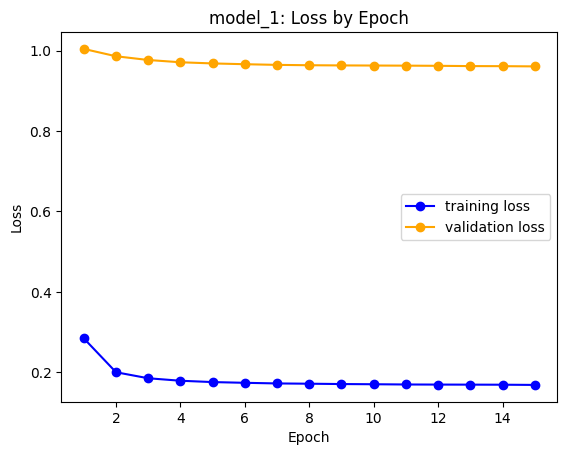

148070 21914 0 0
(1.0, 1.0)


In [33]:
# analyze
with open("models/models.json", "r") as file:
    saved_models = json.load(file)
model_name = f'model_{len(saved_models)}'
color_list = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

def confusion_matrix():
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for i in range(len(historical_label)):
        pred_benign = (historical_pred[i] <= reconstruction_l2)
        truth_benign = (historical_label[i] < 0.5)
        if truth_benign:
            if pred_benign:
                tp += 1
            else:
                fn += 1
        else:
            if pred_benign:
                fp += 1
            else:
                tn += 1
    print(tp, fp, fn, tn)
    tpr = tp / (tp + fn)
    fpr = fp / (tn + fp)
    return (tpr, fpr)

historical_pred = torch.cat(historical_pred_tensor).tolist()
historical_label = torch.cat(historical_label_tensor).tolist()

# epoch loss
loss_plt, ax = plt.subplots()
ax.plot(range(1, len(historical_loss) + 1), historical_loss, marker='o', color='blue', label="training loss")
ax.plot(range(1, len(historical_val_loss) + 1), historical_val_loss, marker='o', color='orange', label="validation loss")
ax.set_title(f'{model_name}: Loss by Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show(loss_plt.number)

print(confusion_matrix())

# chart, name
charts = [(loss_plt, f"charts/{model_name}-loss.jpg")]

In [ ]:
# review
save_path = f"models/{model_name}.pth"
model_object = {
    "path": save_path,
    "lr": float(lr),
    "beta1": float(beta1),
    "beta2": float(beta2),
    "weight_decay": float(weight_decay),
    "epochs": int(epochs),
    "loss_fn": str(loss_fn.__str__()),
    "train_loss": float(train_loss),
    "val_loss": float(epoch_val_loss),
    "test_loss": float(test_loss),
    "auc": float(roc_auc),
    "desc": str(model_desc),
    "acc_maxima": [{
        "thresh": float(thresh),
        "acc": float(acc),
        "tpr": float(tpr),
        "fpr": float(fpr),
    } for thresh, acc, tpr, fpr, _ in maxima_accuracies],
    "charts": [name for _, name in charts],
}
json_str = json.dumps(model_object, indent=4)

print(json_str)

{
    "path": "models/model_0.pth",
    "lr": 1e-05,
    "beta1": 0.9,
    "beta2": 0.999,
    "weight_decay": 0.0001,
    "epochs": 10,
    "train_loss": 3.7042347132364725e-05,
    "val_loss": 7.136520809089008e-05,
    "test_loss": 0.001210725143242777,
    "auc": 0.6394643491528037,
    "desc": "DNN(\n  (input): Linear(in_features=158, out_features=79, bias=True)\n  (output): Linear(in_features=39, out_features=1, bias=True)\n  (dropout): Dropout(p=0.2, inplace=False)\n  (hiddens): ModuleList(\n    (0): Linear(in_features=79, out_features=39, bias=True)\n  )\n)",
    "acc_maxima": [
        {
            "thresh": 0.020202020183205605,
            "acc": 0.7818196614583334,
            "tpr": 0.8686037255214137,
            "fpr": 0.7174390914086829
        },
        {
            "thresh": 0.12121212482452393,
            "acc": 0.8392198350694444,
            "tpr": 0.9823594968953988,
            "fpr": 0.9842461989375344
        },
        {
            "thresh": 0.85858583450

In [ ]:
# save
save = input("save (y/n): ")
if save == "y":
    torch.save(model.state_dict(), save_path)
    notes = input("notes: ")
    model_object['notes'] = notes

    for chart, name in charts:
        chart.savefig(name, dpi=300)

    with open("models/models.json", "r") as file:
        saved_models = json.load(file)
        saved_models.append(model_object)
    with open("models/models.json", "w") as file:
        json.dump(saved_models, file, indent=4)